In [37]:
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

In [119]:
import os
import cv2
import numpy as np
import pandas as pd

In [44]:
import torch.utils.data as data
from torch_snippets import read, subplots, show

In [40]:
data_root = "data"
labels_df = pd.read_csv(os.path.join(data_root, "df.csv"))
labels_df.head(10)

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452
5,0002914fa805e227,xclick,Truck,1,0.061250,0.966875,0.125399,0.974495,1,0,...,1,0,0.756875,0.966875,0.501875,0.061250,0.974495,0.598300,0.125399,0.382572
6,00036603fa39fa85,xclick,Truck,1,0.058125,0.983125,0.053333,0.940000,0,0,...,0,0,0.058125,0.598750,0.983125,0.710000,0.550000,0.053333,0.337778,0.940000
7,0004d5a9dd44ab6a,xclick,Truck,1,0.035625,0.188125,0.189893,0.320827,0,0,...,0,0,0.115000,0.035625,0.139375,0.188125,0.189893,0.245023,0.320827,0.236600
8,0004d5a9dd44ab6a,xclick,Truck,1,0.094375,0.897500,0.147014,0.934150,0,0,...,0,0,0.365000,0.094375,0.333750,0.897500,0.147014,0.609495,0.934150,0.822358
9,0004d5a9dd44ab6a,xclick,Truck,1,0.860625,0.999375,0.249617,0.390505,1,0,...,0,0,0.992500,0.999375,0.860625,0.921250,0.249617,0.294028,0.325421,0.390505


In [153]:
class ImageDataset(data.Dataset):
    def __init__(self, labels_df, image_folder="data/images/images"):
        self.image_root_dir = image_folder
        self.df = labels_df
        self.image_ids = self.df['ImageID'].unique()
    
    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_root_dir, f"{img_id}.jpg")
        img = cv2.imread(img_path, 1)[...,::-1] # conver BGR to RGB
        h, w, _ = img.shape
        df = self.df.copy()
        df = df[df['ImageID'] == img_id]
        boxes = df[['XMin','YMin','XMax','YMax']].values
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return img, boxes, classes, img_path

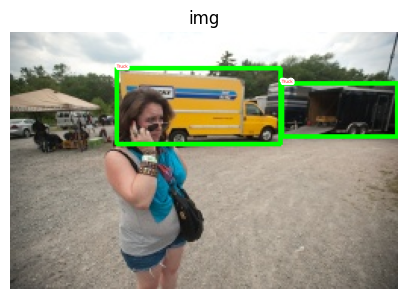

data/images/images/00006bdb1eb5cd74.jpg


In [182]:
img_ds = ImageDataset(labels_df)
img, true_boxes, true_classes, img_path =img_ds[1]
show(img, bbs=true_boxes, texts=true_classes)
print(img_path)

In [184]:
true_classes

['Truck', 'Truck']

In [185]:
len(img_ds)

15225

In [186]:
int(len(img_ds) * 0.8)

12180

## One time process for fetching all 

In [187]:
from preprocesses import extract_candidate_boxes, iou_score

In [188]:
img_h,img_w,_ = img.shape
cand_boxes = extract_candidate_boxes(img)
cand_boxes

/usr/local/lib/python3.10/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


[(0, 0, 118, 32),
 (76, 0, 138, 25),
 (109, 73, 146, 96),
 (0, 78, 82, 91),
 (107, 73, 148, 96),
 (76, 0, 138, 27),
 (0, 23, 117, 75),
 (0, 78, 102, 91),
 (123, 22, 132, 47),
 (0, 78, 126, 91),
 (0, 36, 150, 133),
 (0, 23, 125, 123),
 (118, 22, 137, 48),
 (0, 0, 182, 67),
 (0, 0, 253, 67),
 (107, 62, 148, 107),
 (0, 23, 150, 146),
 (0, 23, 255, 146),
 (0, 0, 255, 67),
 (76, 0, 138, 29),
 (0, 0, 255, 70),
 (0, 0, 255, 169)]

In [197]:
cand_boxes = np.array([(x,y,x+w,y+h) for x,y,w,h in cand_boxes])
cand_boxes

array([[  0,   0, 118,  32],
       [ 76,   0, 290,  25],
       [109,  73, 364, 242],
       [  0,  78,  82, 247],
       [107,  73, 362, 242],
       [ 76,   0, 290,  27],
       [  0,  23, 117, 121],
       [  0,  78, 102, 247],
       [123,  22, 378,  91],
       [  0,  78, 126, 247],
       [  0,  36, 150, 205],
       [  0,  23, 125, 169],
       [118,  22, 373,  92],
       [  0,   0, 182,  67],
       [  0,   0, 253,  67],
       [107,  62, 362, 231],
       [  0,  23, 150, 192],
       [  0,  23, 255, 192],
       [  0,   0, 255,  67],
       [ 76,   0, 290,  29],
       [  0,   0, 255,  70],
       [  0,   0, 255, 169]])

In [198]:
cand_boxes.shape

(22, 4)

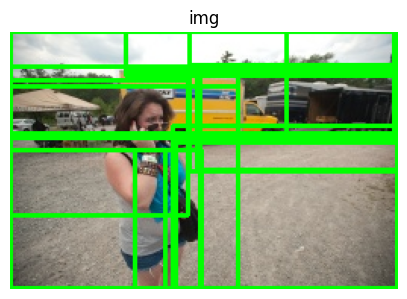

In [199]:
show(img, bbs=cand_boxes)

In [210]:
# iou scores for candidate boxes vs true boxes for one image
cand_ious = []

# RoIs locations for candidate boxes vs true boxes for one image
cand_rois = []

# classes for candidate boxes vs true boxes for one image
cand_classes = []

# box offsets for candidate boxes vs true boxes for one image
cand_deltas = []

In [211]:
cand_ious = np.array([[iou_score(c_box, t_box) for c_box in cand_boxes] for t_box in true_boxes]).T
cand_ious

array([[0.04367607, 0.        ],
       [0.00957926, 0.        ],
       [0.00142485, 0.        ],
       [0.        , 0.        ],
       [0.00146622, 0.        ],
       [0.0281457 , 0.        ],
       [0.16189033, 0.        ],
       [0.        , 0.        ],
       [0.13583601, 0.15117931],
       [0.        , 0.        ],
       [0.10970769, 0.        ],
       [0.13157895, 0.        ],
       [0.14814815, 0.14901961],
       [0.35861004, 0.00670959],
       [0.26226916, 0.14223309],
       [0.017883  , 0.01176393],
       [0.14953271, 0.        ],
       [0.12530456, 0.0617241 ],
       [0.26029931, 0.14550096],
       [0.04596251, 0.        ],
       [0.2717427 , 0.14901961],
       [0.12530456, 0.0617241 ]])

In [ ]:
for j, cand_box in enumerate(cand_boxes):
    

In [201]:
cand_ious.shape

(22, 2)

In [202]:
cand_ious[:11]

array([[0.04367607, 0.        ],
       [0.00957926, 0.        ],
       [0.00142485, 0.        ],
       [0.        , 0.        ],
       [0.00146622, 0.        ],
       [0.0281457 , 0.        ],
       [0.16189033, 0.        ],
       [0.        , 0.        ],
       [0.13583601, 0.15117931],
       [0.        , 0.        ],
       [0.10970769, 0.        ]])

In [203]:
cand_ious[11:]

array([[0.13157895, 0.        ],
       [0.14814815, 0.14901961],
       [0.35861004, 0.00670959],
       [0.26226916, 0.14223309],
       [0.017883  , 0.01176393],
       [0.14953271, 0.        ],
       [0.12530456, 0.0617241 ],
       [0.26029931, 0.14550096],
       [0.04596251, 0.        ],
       [0.2717427 , 0.14901961],
       [0.12530456, 0.0617241 ]])

In [204]:
cand_box = cand_boxes[0]
cand_box

array([  0,   0, 118,  32])

In [205]:
cx1, cy1, cx2, cy2 = cand_box

In [206]:
cand_iou = cand_ious[0]
cand_iou

array([0.04367607, 0.        ])

In [208]:
best_iou_idx = int(np.argmax(cand_iou))
best_iou_idx

0

In [209]:
best_iou = cand_iou[best_iou_idx]

In [ ]:
best_cand_box = 